# Reduce

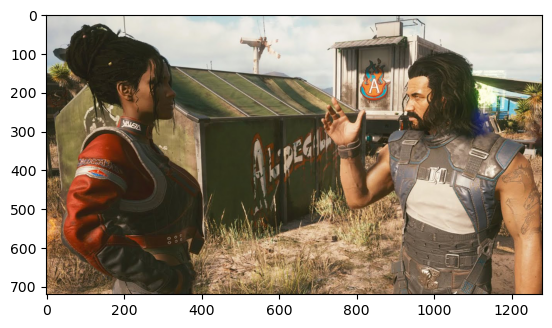

uint8
(720, 1280, 3)
Original: min = 0, max = 255
min = 8, max = 254
min = 8, max = 254


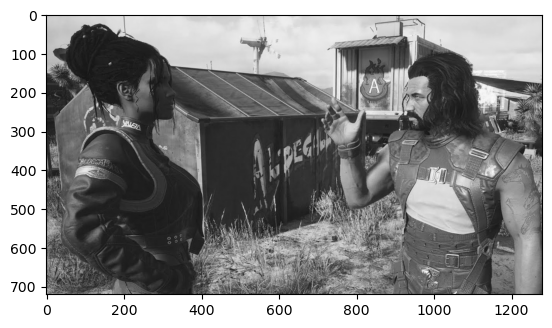

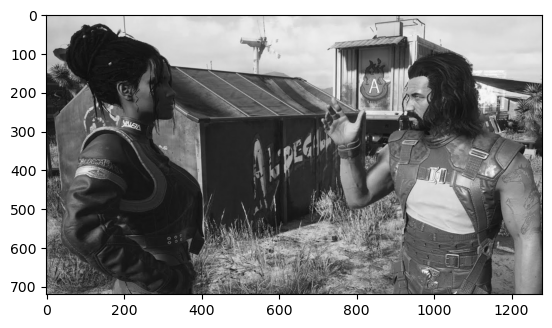

Processing time: 0.28 seconds


In [32]:
import numba
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import time

hostInp=plt.imread("../images/maxresdefault.jpg")
plt.imshow(hostInp)
plt.show()
print(hostInp.dtype)
(H,W,C) = hostInp.shape
print(hostInp.shape)
max_w = np.max(hostInp)
min_w = np.min(hostInp)
print(f"Original: min = {min_w}, max = {max_w}")
pixelcount= H*W
hostInp=hostInp.reshape((pixelcount,3))

devOut = cuda.device_array((pixelcount, C), np.uint8)
devOut2 = cuda.device_array((pixelcount, C), np.uint8)

min_val = cuda.to_device(np.array([255], dtype=np.int32))
max_val = cuda.to_device(np.array([0], dtype=np.int32))

hostOut=np.zeros((H,W,C),np.uint8)

devInp=cuda.to_device(hostInp)

@cuda.jit
def grayscale_threshold(src, dst, min_val,max_val):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if tidx < src.shape[0]: 
        g = np.uint8((float(src[tidx, 0]) + float(src[tidx, 1]) + float(src[tidx, 2])) / 3)
        dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g
        cuda.atomic.min(min_val, 0, int(g))
        cuda.atomic.max(max_val, 0, int(g))

@cuda.jit
def changing(src, dst, min_val,max_val):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if tidx < src.shape[0]: 
        g = src[tidx, 0]
        min_g = min_val[0]
        max_g = max_val[0]
        gg = (g - min_g) * 255 / (max_g - min_g) 
        dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = np.uint8(gg)



blockSize = 64
gridSize = (pixelcount + blockSize - 1) // blockSize
t1 = time.time()
grayscale_threshold[gridSize, blockSize](devInp, devOut, min_val,max_val)
cuda.synchronize()
hostOut = devOut.copy_to_host().reshape(H, W, C)

max_w = np.max(hostOut)
min_w = np.min(hostOut)
min_r = min_val.copy_to_host()[0]
max_r = max_val.copy_to_host()[0]
print(f"min = {min_r}, max = {max_r}")
print(f"min = {min_w}, max = {max_w}")
plt.imshow(hostOut)
plt.show()

changing[gridSize, blockSize](devOut, devOut2, min_val,max_val)
cuda.synchronize()
hostOut2 = devOut2.copy_to_host().reshape(H, W, C)

t2 = time.time()
#plt.imshow(hostOut)
plt.imshow(hostOut2)
plt.show()
print(f"Processing time: {t2 - t1:.2f} seconds")
if np.array_equal(hostOut, hostOut2):
    print("The images are the same.")